## This Notebook calculates the number of genes mentioned in the GPT 4 analysis paragraph 

In [1]:
def get_LLM_gene_count(genes_fixed, LLM_analysis):
    system_genes_set = set(genes_fixed.split(" "))
    # Count the number of genes in the set that are mentioned in the LLM analysis
    overlaps = sum(1 for system_gene in system_genes_set if system_gene in LLM_analysis) 
    return overlaps

In [3]:
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

perc_gene_mentioned = []
counts = []
for ind, row in df.iterrows():
    genes = row['Genes']
    genecount = float(row['Gene_Count'])
    assert genecount == len(genes.split(" ")) # make sure the gene count is correct
    
    analysis = row['gpt_4_default Analysis']
    overlap_counts = get_LLM_gene_count(genes, analysis)
    counts.append(overlap_counts)
    perc_gene_mentioned.append(overlap_counts/genecount)

df['num_gene_mentioned'] = counts
df['perc_gene_mentioned'] = perc_gene_mentioned

df.to_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t', index=False)

In [ ]:
df['perc_gene_mentioned'].describe()

count    1000.000000
mean        0.811926
std         0.302239
min         0.015487
25%         0.638369
50%         1.000000
75%         1.000000
max         1.000000
Name: perc_gene_mentioned, dtype: float64

In [6]:
# find the number of times that covers at least 90% of the genes

print("Number of GO terms that cover at least 90% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.9)))
print("Number of GO terms that cover at least 50% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.5)))

Number of GO terms that cover at least 90% of the genes: 797
Number of GO terms that cover at least 50% of the genes: 942


In [7]:
#check the size of the GO terms for outliers
import numpy as np

# Calculate quartiles and IQR
q1 = np.percentile(df['perc_gene_mentioned'], 25)
q3 = np.percentile(df['perc_gene_mentioned'], 75)
iqr = q3 - q1

# Calculate the upper and lower bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Extract the outliers from the DataFrame
outliers = df[(df['perc_gene_mentioned'] < lower_bound) | (df['perc_gene_mentioned'] > upper_bound)]
print('lower bound: {}'.format(lower_bound))
print("Number of outliers: {}".format(len(outliers)))
# outliers size distribution
outliers['Gene_Count'].describe()

lower bound: 0.8652777777777778
Number of outliers: 186


count    186.000000
mean      55.854839
std       20.657710
min        6.000000
25%       40.000000
50%       53.000000
75%       72.000000
max      100.000000
Name: Gene_Count, dtype: float64

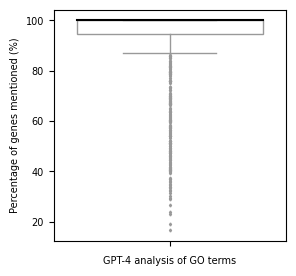

In [10]:
## plot a box plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
perc_gene_mentioned = df['perc_gene_mentioned'].tolist()
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
fig,ax = plt.subplots(figsize=(3,3))

box_plot = sns.boxplot(y=[frac *100 for frac in perc_gene_mentioned], ax=ax, color='white', linewidth=1, fliersize=1.5)

# changing color and linewidth of the median line
median_line = box_plot.get_lines()[4] # get the median line
median_line.set_color('black') # change the color
median_line.set_linewidth(1.5) # change the linewidth

ax.set_ylabel("Percentage of genes mentioned (%)")
ax.set_xlabel("GPT-4 analysis of GO terms")

plt.savefig('./figures/LLM_GO_gene_mention_percentage.svg', dpi = 300,bbox_inches='tight')
plt.show()

In [3]:
## collect top 10 and bottom 10 
import pandas as pd 
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
# not include the 'System of unrelated proteins'
df.drop(df[df['gpt_4_default Name'] == 'System of unrelated proteins'].index, inplace = True)
df = df.sort_values(by='true_GO_term_sim_percentile', ascending=False)
top = df.head(10)
bottom = df.tail(10)
combine_df = pd.concat([top,bottom], ignore_index=True)
combine_df.to_csv('./data/GO_term_analysis/LLM_processed_GO_representative_top_bottom_10.tsv', sep='\t', index=False)
combine_df

,GO,Genes,Gene_Count,Term_Description,gpt_4_default Name,gpt_4_default Analysis,gpt_4_default Score,gpt_4_default Score Bin,LLM_name_GO_term_sim,sim_rank,...,top_3_hits,top_3_sim,pvals,adj_pvals,random_pvals,random_adj_pvals,JI,random JI,num_gene_mentioned,perc_gene_mentioned
0,GO:1901490,FOXC1 VASH1 EPHA2 VEGFC CCBE1,5,regulation of lymphangiogenesis,Angiogenesis and Lymphangiogenesis Regulation,1. FOXC1 is a transcription factor that plays ...,0.92,High Confidence,0.844656,1,...,regulation of lymphangiogenesis|regulation of ...,0.84465593|0.82013255|0.77059066,8.399547588454023e-20|1.2705147540614079e-09|1.0,4.097340287050743e-19|4.059152568886287e-09|1.0,1.0,1.0,1.0|0.017543859649122806|0.0,0.0,5,1.000000
1,GO:0019227,FKBP1B SCN1B CLDN19 NRCAM CNTNAP1 SCN1A NTRK2 ...,9,neuronal action potential propagation,Neuronal Excitability and Signal Propagation,"1. FKBP1B, also known as FKBP12.6, is a member...",0.92,High Confidence,0.765605,1,...,neuronal action potential propagation|transmis...,0.7656047|0.7362392|0.7316712,3.0294007827870004e-33|2.5784140433588196e-22|1.0,2.348372699834884e-32|1.57220368497489e-21|1.0,1.0,1.0,1.0|0.125|0.0,0.0,9,1.000000
2,GO:0090183,PAX8 WNT4 BASP1 GDNF SOX9 TACSTD2 GREM1 HNF1B ...,34,regulation of kidney development,Kidney Development and Function Regulation,"1. Several proteins in this system, including ...",0.92,High Confidence,0.912659,1,...,regulation of kidney development|kidney develo...,0.91265875|0.8040259|0.7702517,4.2585228799752766e-106|1.991676329704935e-60|...,1.6378934153751065e-104|4.064645570826398e-59|...,1.0,1.0,1.0|0.10793650793650794|0.16279069767441862,0.0,33,0.970588
3,GO:0006406,DDX39B THOC1 NXF1 THOC2 THOC6 THOC5 POLDIP3 NU...,69,mRNA export from nucleus,mRNA Processing and Nuclear Export,"1. The majority of the proteins listed, includ...",0.98,High Confidence,0.855209,1,...,mRNA export from nucleus|mRNA processing|RNA e...,0.8552088|0.8134874|0.7978674,2.2477513106121812e-194|1.3416924342799892e-25...,3.746252184353635e-192|9.253051270896478e-25|1...,1.0,1.0,1.0|0.05333333333333334|0.7666666666666667,0.0,61,0.884058
4,GO:0030208,DSE CHST12 UST CHST14 DSEL,5,dermatan sulfate biosynthetic process,Dermatan Sulfate Biosynthesis and Modification,"1. DSE, also known as dermatan sulfate epimera...",0.92,High Confidence,0.904004,1,...,dermatan sulfate biosynthetic process|dermatan...,0.90400404|0.8094897|0.78539944,8.399547588454023e-20|4.703746649534253e-18|1....,4.097340287050743e-19|2.5288960481366954e-17|6...,1.0,1.0,1.0|0.625|0.5555555555555556,0.0,5,1.000000
5,GO:0060117,CDH23 TMC1 SLITRK6 NHERF1 STRC FGFR1 PAFAH1B1 ...,26,auditory receptor cell development,Auditory System Development and Function,"1. CDH23, TMC1, STRC, TPRN, GRXCR2, CLRN1, CLR...",0.95,High Confidence,0.822126,1,...,auditory receptor cell development|ear develop...,0.8221256|0.79742056|0.7652622,4.0455359329598197e-84|2.833473399495047e-50|1...,9.632228411809094e-83|4.166872646316245e-49|3....,1.0,1.0,1.0|0.11607142857142858|0.07042253521126761,0.0,26,1.000000
6,GO:0002461,FOXP3 HLA-G PSG9 HAVCR2 CD274 AIRE,6,tolerance induction dependent upon immune resp...,Immune Tolerance and Regulation,1. FOXP3 is a transcription factor pivotal for...,0.92,High Confidence,0.889181,1,...,tolerance induction dependent upon immune resp...,0.88918144|0.8759233|0.8353162,2.961410596469864e-23|2.4330413449424417e-11|1...,1.6271486793790462e-22|8.81536719182044e-11|1....,1.0,1.0,1.0|0.5|0.2,0.0,6,1.000000
7,GO:0048240,EFCAB9 ADAM7 TCP11 CATSPER4 SPINK1 BSPH1 ROPN1...,33,sperm capacitation,Sperm Capacitation and Fertilization,1. The majority of the proteins listed are rel...,0.92,High Confidence,0.936600,1,...,sperm capacitation|regulation of sperm capacit...,0.9366003|0.7948351|0.7883392,2.1280089332582335e-103|1.9935150264533243e-14...,7.60003190449369e-102|8.8554274588964e-14|1.01...,1.0,1.0,1.0|0.15151515151515152|0.06060606060606061,0.0,20,0.606061
8,GO:0042417,DBH PNKD COMT ATP7A NR4A2 SNCAIP SLC6A3 GPR37 ...,39,dopamine